In [11]:
import pandas as pd
import numpy as np
import seaborn as sns

In [12]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [13]:
import random

# Работа с вопросом

**Вопрос:** станет ли лучше от использования нового алгоритма рекомендаций?

## Что значит, что стало «лучше»

1. Пользователи стали покупать больше товаров.
2. Пользователи стали проводить в приложении больше времени.
3. Удовлетворённость пользователей от рекомендаций выросла.
4. ...

**Переформулированный вопрос:** приведёт ли внедрение новой системы рекомендаций к увеличению выручки?

## Как оценить, насколько больше денег принесли покупки

### Что считать

1. Суммарная выручка в группе. Так можно, но мы с вами так не умеем: умеем работать со средними значениями (t-тест).
2. Средний чек. Проблема: при увеличении (или уменьшении среднего чека) выручка на самом деле может уменьшиться (или увеличиться).
3. Средняя выручка на одного платящего пользователя. Плохо: число платящих пользователей могло измениться в результате нашего изменения (причём не обязательно в интересную нам сторону). Можно, конечно, следить за несколькими метриками при принятии решения, и это нормальная стратегия, но для нашего случая сложная.
4. Средняя выручка на одного пользователя. Наш выбор, потому что при равенстве контрольной и экспериментальной групп эквивалентна суммарной выручке.

Всё остальное тоже можно посчитать для того, чтобы детальнее понять, за счёт чего достигается положительный эффект (если достигается), или для того, чтобы понять, что же пошло не так...

# Предварительное исследование данных

In [29]:
user = pd.read_csv('user.csv')
user_ab_group = pd.read_csv('user_ab_group.csv')
good = pd.read_csv('good.csv')
user_purchase = pd.read_csv('user_purchase.csv')
purchase_good = pd.read_csv('purchase_good.csv')
#считываем всевозможные данные


In [21]:
user 
#таблица в которой есть информачия о каждом пользователе
#нет пропусков (можно проверить через .isna())

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область
...,...,...,...,...
14995,14996,М,41,Нижегородская область
14996,14997,Ж,30,Астраханская область
14997,14998,М,26,Краснодарский край
14998,14999,М,36,Оренбургская область


### Описательные статистики по пользователям

In [10]:
user

,user_id,gender,age,region
0,1,Ж,23,Краснодарский край
1,2,Ж,43,Краснодарский край
2,3,М,36,Краснодарский край
3,4,Ж,39,Краснодарский край
4,5,М,43,Иркутская область
...,...,...,...,...
14995,14996,М,41,Нижегородская область
14996,14997,Ж,30,Астраханская область
14997,14998,М,26,Краснодарский край
14998,14999,М,36,Оренбургская область


In [111]:
user_ab_group
#всего 11915 => в выборке учавстуют не все 
#control - A группа (контрольная)
#treatment - B группа (эксперимантальная)


,user_id,group
0,5034,treatment
1,4725,treatment
2,911,treatment
3,13267,control
4,5636,control
...,...,...
11910,7599,control
11911,11476,treatment
11912,805,treatment
11913,1743,treatment


<Axes: xlabel='age', ylabel='Count'>

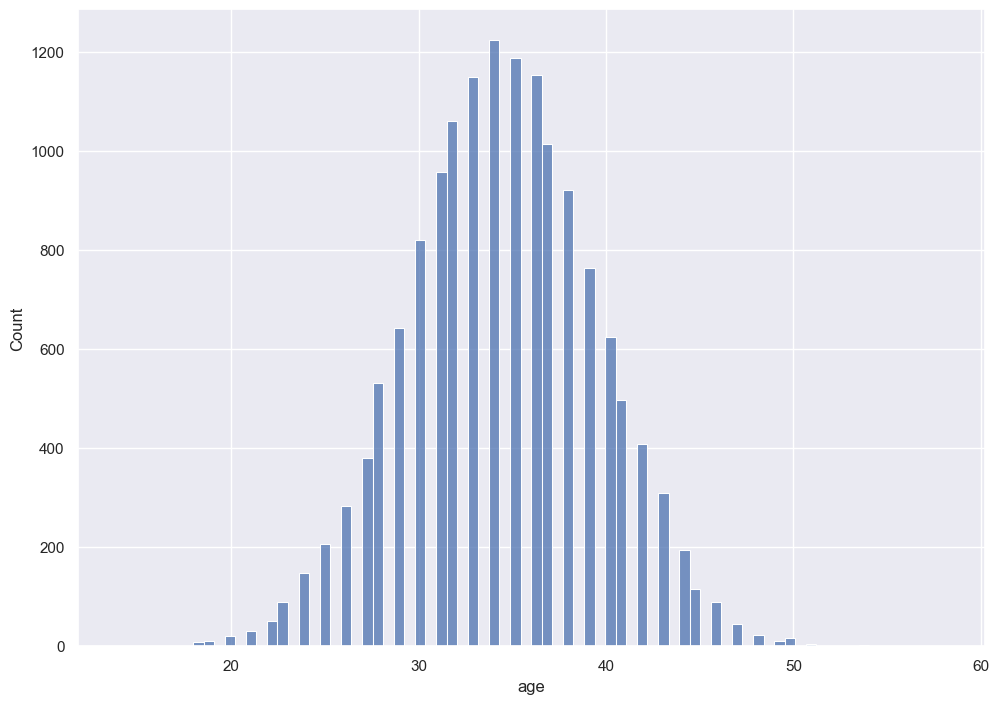

In [6]:
sns.histplot(user['age'])
#график распределения возраста
#распределение нормальное
#ср знач 30-40

In [7]:
user['gender'].value_counts()
#функция .value_counts() считает сколько каждый элемент и series'а встречался в нем (частотный словарь)
#почти равное распределение М и Ж

Ж    7636
М    7364
Name: gender, dtype: int64

In [8]:
user['region'].value_counts()
#частотный словарь для региона

Краснодарский край       4674
Санкт-Петербург          3474
Иркутская область        2222
Нижегородская область    2036
Оренбургская область     1559
Астраханская область      735
Республика Адыгея         300
Name: region, dtype: int64

### Описательные статистики по покупкам

In [9]:
good
#таблица содержит id - id товара

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480
...,...,...,...
95,96,Органическая кокосовая мука,616
96,97,Семена чиа в меде,379
97,98,Кардамон органический,459
98,99,Куркума в порошке,647


In [113]:
purchase_good
#в этой таблицы good_id - это id в табице good

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True
...,...,...,...,...
352052,53057,54,1,False
352053,72053,37,1,False
352054,72053,7,1,False
352055,72053,24,1,True


In [10]:
purchase_good['good_id'].value_counts()
#частотный словарь,где первый столбец - это id товара из таблицы good

91    6306
93    5975
44    5768
30    5697
37    5588
      ... 
57    1131
18     905
96     578
77     574
45     483
Name: good_id, Length: 100, dtype: int64

In [30]:
purchase_good \
    .merge(good, left_on='good_id', right_on='id') \
    .groupby('good_name', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'cnt'}) \
    .sort_values('cnt', ascending=False) \
    .head(10)

#снизу разбор по отдельным методам

,good_name,cnt
0,Авокадо-масло,6306
28,Кедровые чипсы,5975
44,Лосось вяленый,5768
59,Морская капуста сушёная,5697
3,Амарантовые хлопья,5588
32,Киноа-бургеры,5502
14,Горькая шоколадная плитка с высоким содержание...,5495
19,Грецкие орехи,5422
10,Бразильские орехи,5406
49,Льняные хлопья,5324


In [26]:
good = pd.read_csv('good.csv')
user_purchase = pd.read_csv('user_purchase.csv')
purchase_good = pd.read_csv('purchase_good.csv')
#присоединяем к таблицы purchase_good таблицу good по значениям столбцов good_id и id
purchase_good = purchase_good.merge(good, left_on='good_id', right_on='id')
purchase_good

,purchase_id,good_id,amount,was_in_recommended_goods,id,good_name,price_per_unit
0,15495,34,2,False,34,Кишмиш-жмых,464
1,42640,48,1,False,48,Спаржа свежая,584
2,42640,36,1,False,36,Льняные хлопья,404
3,42640,12,2,True,12,Льняное масло холодного отжима,495
4,42640,35,1,True,35,Семена чиа в желе,618
...,...,...,...,...,...,...,...
352052,53057,54,1,False,54,Органический базилик,647
352053,72053,37,1,False,37,Амарантовые хлопья,509
352054,72053,7,1,False,7,Киноа органическая,572
352055,72053,24,1,True,24,Кедровая мука,665


In [27]:
purchase_good = purchase_good.groupby('good_name', as_index=False) \
    .agg({'id': 'count'})
purchase_good
#групируем по именам товаров и аггрегируем 
#в колонку id будет записанно количество того, сколько раз id встретился в этом столбце
#таким образом у нас появился таблица длинной 100 (количество уникальных товаров)
#справа от имени товара пишется сколько раз его купили


,good_name,id
0,Авокадо-масло,6306
1,Агавовый нектар,5048
2,Алоэ вера напиток,1396
3,Амарантовые хлопья,5588
4,Ананас сушёный,3804
...,...,...
95,Шпинат органический,4022
96,Ягоды асаи в порошке,2846
97,Ягоды годжи,4170
98,Ягоды черники свежие,4077


In [28]:
purchase_good = purchase_good.rename(columns={'id': 'cnt'}) \
    .sort_values('cnt', ascending=False) \
    .head(10)
purchase_good
#переименовываем колонку id в колонку cnt так как там по у нас записано количество покупок конкретного товара
# сортируем по cnt по убыванию
#выводим первые 10

,good_name,cnt
0,Авокадо-масло,6306
28,Кедровые чипсы,5975
44,Лосось вяленый,5768
59,Морская капуста сушёная,5697
3,Амарантовые хлопья,5588
32,Киноа-бургеры,5502
14,Горькая шоколадная плитка с высоким содержание...,5495
19,Грецкие орехи,5422
10,Бразильские орехи,5406
49,Льняные хлопья,5324


In [31]:
purchase_good \
    .merge(good, left_on='good_id', right_on='id') \
    .groupby('good_name', as_index=False) \
    .agg({'id': 'count'}) \
    .rename(columns={'id': 'cnt'}) \
    .sort_values('cnt', ascending=False) \
    .tail(5)
#выводим полседние 5 

,good_name,cnt
94,Шоколадные коктейльные протеины,1131
92,Чёрная рисовая мука,905
63,Органическая кокосовая мука,578
51,Масло авокадо,574
15,Горький миндальный шоколад,483


In [33]:
user_purchase
#id - id покупки
#user_id- id пользователя равный id в таблице user 

,id,user_id,date_time
0,1,5784,2023-09-20 00:01:07
1,2,4468,2023-09-20 00:04:18
2,3,3827,2023-09-20 00:04:35
3,4,3272,2023-09-20 00:06:32
4,5,9461,2023-09-20 00:08:24
...,...,...,...
74946,74947,5634,2023-11-28 23:52:18
74947,74948,5318,2023-11-28 23:54:22
74948,74949,14345,2023-11-28 23:55:03
74949,74950,795,2023-11-28 23:57:06


In [34]:
user_purchase['date_time']
#пока что тип данных в колонке 'date_time' object

0        2023-09-20 00:01:07
1        2023-09-20 00:04:18
2        2023-09-20 00:04:35
3        2023-09-20 00:06:32
4        2023-09-20 00:08:24
                ...         
74946    2023-11-28 23:52:18
74947    2023-11-28 23:54:22
74948    2023-11-28 23:55:03
74949    2023-11-28 23:57:06
74950    2023-11-28 23:57:51
Name: date_time, Length: 74951, dtype: object

In [35]:
user_purchase['date_time'].dtype

dtype('O')

In [36]:
user_purchase['date_time'] = pd.to_datetime(user_purchase['date_time'], format='%Y-%m-%d %H:%M:%S')
#приводим его к виду времени Timestamp

In [37]:
user_purchase['date_time'].dtype

dtype('<M8[ns]')

In [38]:
user_purchase['date_time'].max()

Timestamp('2023-11-28 23:57:51')

In [39]:
user_purchase['date_time'].min()

Timestamp('2023-09-20 00:01:07')

In [40]:
(user_purchase['date_time'].max() - user_purchase['date_time'].min()).days
#количество дней охватываемых нашими данными

69

<Axes: xlabel='date_time', ylabel='Count'>

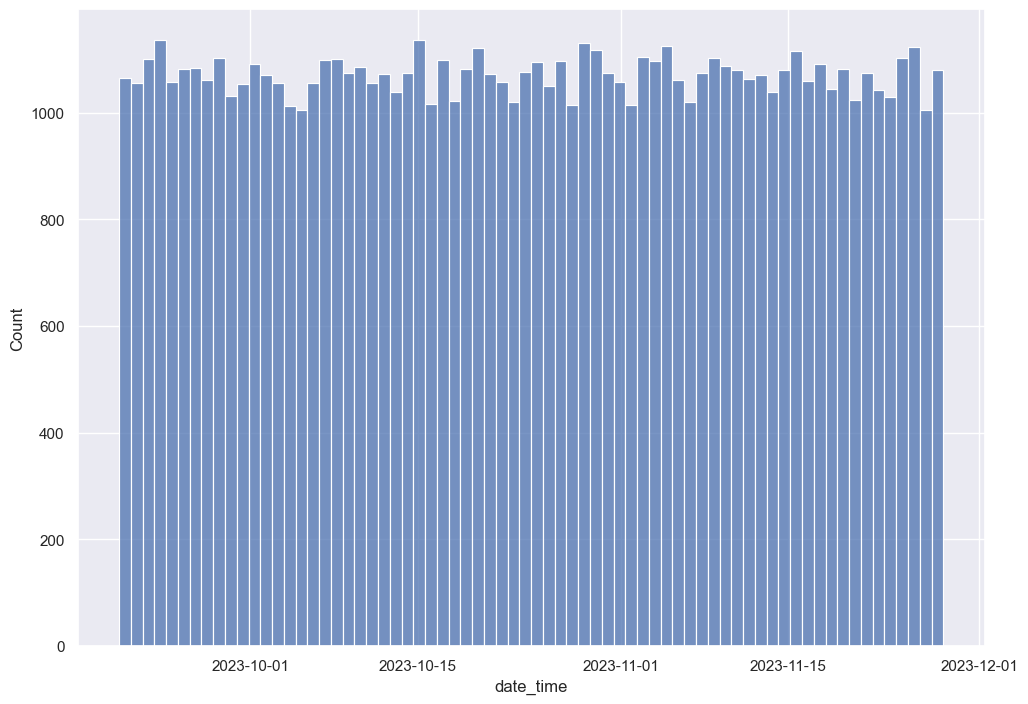

In [133]:
sns.histplot(user_purchase['date_time'].dt.floor('D'), bins=70)
#график покупок в день (bins = 70 так как дней 69)
#по графику не видно приироста после внедрения нового алгоритма рекомендаций 

### Проверка разбиения на группы в рамках эксперимента

In [48]:
treatment_user_ids = frozenset(user_ab_group[user_ab_group['group'] == 'treatment']['user_id'])
control_user_ids = frozenset(user_ab_group[user_ab_group['group'] == 'control']['user_id'])
#в каждую из переменных мы присваем множество уникальных айдишников из определнной группы

In [49]:
treatment_user_ids & control_user_ids
#смотрим есть ли у нас пересечения в них 
#если да, то мы нарушаем требования со стороны математического аппарата
#так как у нас сбивается статистика ведь найдутся выбросы 

#по итогу пересечение множеств пустое 

frozenset()

In [50]:
len(treatment_user_ids), len(control_user_ids)
#в множествах примерно равное количество элементов

(5990, 5925)

In [51]:
our_diff = len(treatment_user_ids) - len(control_user_ids)


In [52]:
our_diff
#разника в количестве всего 65, отбор элементов производился случайно

65

Может ли иметь место Sample Ratio Mismatch (SRM)?

In [45]:
diffs = []

for i in range(10_000):
    arr = [random.randint(0, 1) for i in range(len(user_ab_group))]
    diff = sum(arr) - (len(arr) - sum(arr))
    diffs.append(diff)
#проверяем, могло ли получится такое распределение
# 10 000 раз сгенерируем случайные числа либо 0 либо 1
# сделаем это столько раз, сколько людей у нас отобранно в обе группы
# пусть 1 означает, что пользователь попал в эксперементальную группу а 0 в контрольную ( не имеет значения ) 
#тогда разница для такого распределения (diff) -
#это сумма (количество единиц равно сумме единиц то есть это количество в эксперементальном) - (общее число - эта же сумма)
#да эта сумма может быть отрицательным но это не имеет значения так как разность величина абсолютная + график должен получится куполообразным
#сохраним все 10 000 разниц в массив 

In [46]:
diffs_s = pd.Series(diffs)
# преобразоываем массив в pd.Series

<Axes: ylabel='Count'>

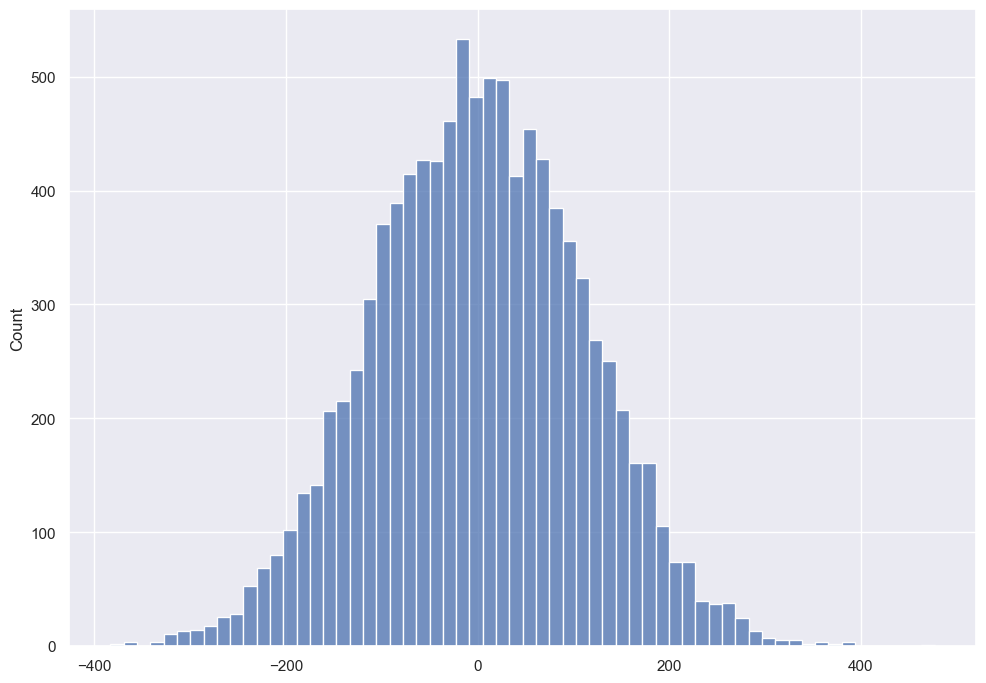

In [47]:
sns.histplot(diffs_s)
#строим график

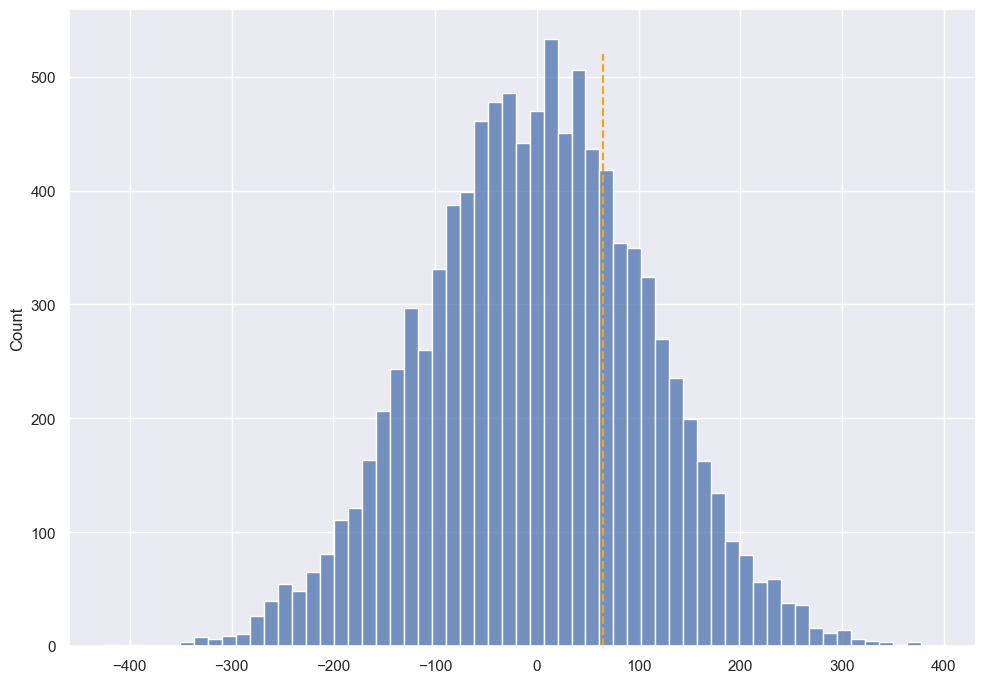

In [28]:
ax = sns.histplot(diffs)
ax.vlines(our_diff, 0, 520, linestyles='dashed', color='orange') # первый аргумент - это наше текущая разница
# 0 - 520 это высота на которой дожна построится линия
#стиль линии пунктирная
#цвет оранжевый

In [29]:
from math import floor

alpha = 0.05
#альфа из ошибки 1 рода - границы выходя за которые мы понимаем что есть ошибки
half_alpha = floor(len(diffs_s) * alpha / 2)

diffs_cut = sorted(diffs_s)[half_alpha:-half_alpha]
#создаем осортированных список с границами  в *полу альфах тем самым diffs_cut[0] -левая граница а diffs_cut[-1] правая

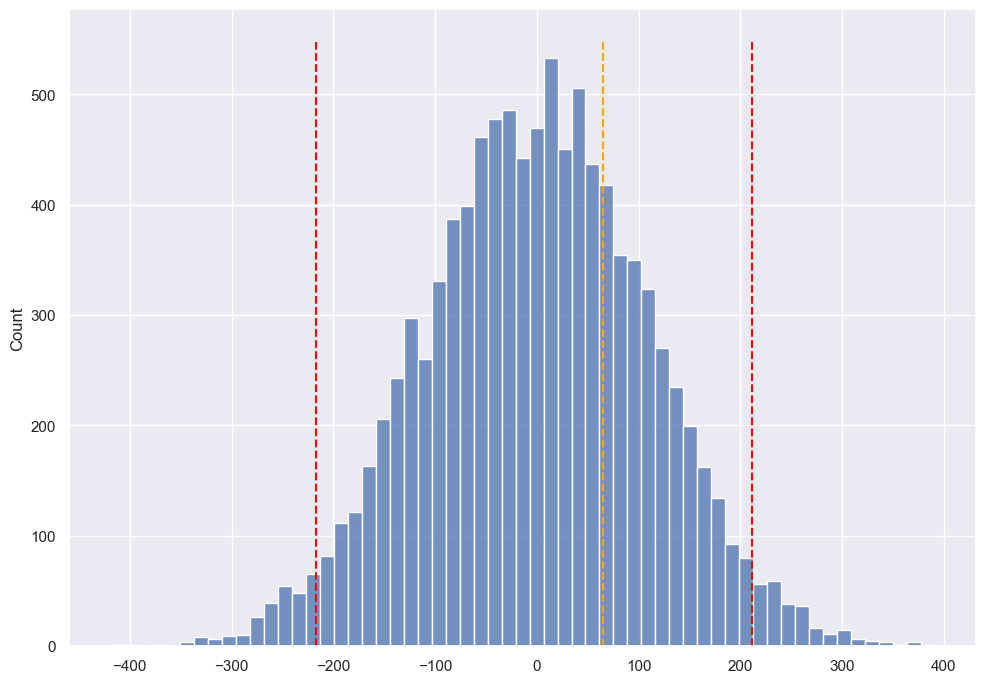

In [30]:
ax = sns.histplot(diffs)

ax.vlines([our_diff], 0, 550, linestyles='dashed', color='orange')
ax.vlines([diffs_cut[0], diffs_cut[-1]], 0, 550, linestyles='dashed', color='red')
#строим новый график и видим что наше значение в пределах нормы и наше разбиение на группы было создано нормально

# Поиск ответа на вопрос

## План ответа на вопрос

1. Оставим информацию только про покупки нужных нам пользователей в период проведения эксперимента (с 01.10.23 по 14.10.23).
2. Вычислим выручку для каждого из пользователей.
3. Сравним средние выручки в контрольной и экспериментальной группах с помощью t-теста.
4. Проинтерпретируем полученный результат.

## 1. Оставляем нужные нам покупки

In [31]:
from datetime import datetime

In [32]:
exp_start_date = datetime(year=2023, month=10, day=1)
exp_end_date = datetime(year=2023, month=10, day=15)
# по условию это даты когда начался и закончился эксперимент 

In [33]:
needed_purchases = \
    user_purchase[(user_purchase['date_time'] >= exp_start_date) & (user_purchase['date_time'] < exp_end_date)]
#отфильтровываем покупки только в нужные даты
treatment_purchases = needed_purchases[needed_purchases['user_id'].isin(treatment_user_ids)]
control_purchases = needed_purchases[needed_purchases['user_id'].isin(control_user_ids)]

In [34]:
len(treatment_purchases), len(control_purchases)

(5879, 5944)

## 2. Вычисляем выручку для каждого из пользователей

In [35]:
good

,id,good_name,price_per_unit
0,1,Органический авокадо,336
1,2,Льняные семена,796
2,3,Кокосовое масло Extra Virgin,558
3,4,Гречка цельнозерновая,484
4,5,Лосось дикого копчения,480
...,...,...,...
95,96,Органическая кокосовая мука,616
96,97,Семена чиа в меде,379
97,98,Кардамон органический,459
98,99,Куркума в порошке,647


In [175]:
purchase_good

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True
...,...,...,...,...
352052,53057,54,1,False
352053,72053,37,1,False
352054,72053,7,1,False
352055,72053,24,1,True


In [36]:
purchase_good_full_info = purchase_good.merge(good, left_on='good_id', right_on='id')
# соединяем две таблицы для подсчета выручки

In [37]:
purchase_good_full_info

,purchase_id,good_id,amount,was_in_recommended_goods,id,good_name,price_per_unit
0,15495,34,2,False,34,Кишмиш-жмых,464
1,6291,34,1,False,34,Кишмиш-жмых,464
2,21060,34,1,False,34,Кишмиш-жмых,464
3,17172,34,1,False,34,Кишмиш-жмых,464
4,29246,34,1,False,34,Кишмиш-жмых,464
...,...,...,...,...,...,...,...
352052,17705,45,1,False,45,Горький миндальный шоколад,591
352053,52109,45,2,False,45,Горький миндальный шоколад,591
352054,24888,45,1,False,45,Горький миндальный шоколад,591
352055,11982,45,1,False,45,Горький миндальный шоколад,591


In [38]:
purchase_good_full_info['paid'] = purchase_good_full_info['amount'] * purchase_good_full_info['price_per_unit']

In [176]:
purchase_good_full_info

,purchase_id,good_id,amount,was_in_recommended_goods,id,good_name,price_per_unit,paid
0,15495,34,2,False,34,Кишмиш-жмых,464,928
1,6291,34,1,False,34,Кишмиш-жмых,464,464
2,21060,34,1,False,34,Кишмиш-жмых,464,464
3,17172,34,1,False,34,Кишмиш-жмых,464,464
4,29246,34,1,False,34,Кишмиш-жмых,464,464
...,...,...,...,...,...,...,...,...
352052,17705,45,1,False,45,Горький миндальный шоколад,591,591
352053,52109,45,2,False,45,Горький миндальный шоколад,591,1182
352054,24888,45,1,False,45,Горький миндальный шоколад,591,591
352055,11982,45,1,False,45,Горький миндальный шоколад,591,591


In [39]:
purchase_full_paid = purchase_good_full_info \
    .groupby('purchase_id', as_index=False) \
    .agg({'paid': 'sum'})


In [177]:
purchase_full_paid
# сколько в рамках каждой покупки было потрачено денег

,purchase_id,paid
0,1,3985
1,2,6095
2,3,3092
3,4,3875
4,5,8411
...,...,...
74946,74947,4382
74947,74948,4863
74948,74949,464
74949,74950,7490


In [40]:
treatment_purchases

,id,user_id,date_time
11832,11833,12987,2023-10-01 00:02:30
11835,11836,4791,2023-10-01 00:07:04
11836,11837,6773,2023-10-01 00:07:21
11839,11840,1933,2023-10-01 00:08:27
11842,11843,12373,2023-10-01 00:12:26
...,...,...,...
26711,26712,1969,2023-10-14 23:51:07
26715,26716,12626,2023-10-14 23:51:41
26716,26717,11774,2023-10-14 23:52:52
26719,26720,4643,2023-10-14 23:55:57


In [41]:
treatment_purchases.merge(purchase_full_paid, left_on='id', right_on='purchase_id')

,id,user_id,date_time,purchase_id,paid
0,11833,12987,2023-10-01 00:02:30,11833,1938
1,11836,4791,2023-10-01 00:07:04,11836,5090
2,11837,6773,2023-10-01 00:07:21,11837,8265
3,11840,1933,2023-10-01 00:08:27,11840,8678
4,11843,12373,2023-10-01 00:12:26,11843,2141
...,...,...,...,...,...
5874,26712,1969,2023-10-14 23:51:07,26712,1138
5875,26716,12626,2023-10-14 23:51:41,26716,4119
5876,26717,11774,2023-10-14 23:52:52,26717,1018
5877,26720,4643,2023-10-14 23:55:57,26720,5554


In [42]:
treatment_purchases.merge(purchase_full_paid, left_on='id', right_on='purchase_id')['paid'].sum()
# cумма котору потратили в эксп группе

26518335

In [43]:
control_purchases.merge(purchase_full_paid, left_on='id', right_on='purchase_id')['paid'].sum()
# сумму которую потратили в контрольной группе

15660483

In [ ]:
#разница в 10 миллиононв
#это могло быть совпадение или ошибка, надо доказать математически


In [44]:
treatment_purchases \
    .merge(purchase_full_paid, left_on='id', right_on='purchase_id') \
    .groupby('user_id', as_index=False) \
    .agg({'paid': 'sum'})

,user_id,paid
0,2,7190
1,6,665
2,10,3587
3,12,640
4,13,7921
...,...,...
4304,14988,1530
4305,14994,2586
4306,14996,6996
4307,14998,6498


In [45]:
treatment_revenue_per_user = treatment_purchases \
    .merge(purchase_full_paid, left_on='id', right_on='purchase_id') \
    .groupby('user_id', as_index=False) \
    .agg({'paid': 'sum'})

control_revenue_per_user = control_purchases \
    .merge(purchase_full_paid, left_on='id', right_on='purchase_id') \
    .groupby('user_id', as_index=False) \
    .agg({'paid': 'sum'})
#создадим таблицу в которой каждому пользователю предоставлена его сумма покупок за период 

In [178]:
treatment_revenue_per_user

,user_id,paid
0,2,7190
1,6,665
2,10,3587
3,12,640
4,13,7921
...,...,...
4304,14988,1530
4305,14994,2586
4306,14996,6996
4307,14998,6498


In [179]:
control_revenue_per_user

,user_id,paid
0,1,928
1,4,447
2,9,559
3,15,5279
4,16,1290
...,...,...
4264,14979,3012
4265,14980,1234
4266,14983,3126
4267,14985,991


## 3. Сравниваем средние в группах с помощью t-теста

In [46]:
treatment_revenues_l = list(treatment_revenue_per_user['paid'])
control_revenues_l = list(control_revenue_per_user['paid'])

In [47]:
len(treatment_revenues_l), len(control_revenues_l)

(4309, 4269)

In [48]:
len(treatment_user_ids), len(control_user_ids)

(5990, 5925)

In [49]:
treatment_revenues_l = treatment_revenues_l + [0] * (len(treatment_user_ids) - len(treatment_revenues_l))
control_revenues_l = control_revenues_l + [0] * (len(control_user_ids) - len(control_revenues_l))
#так как в каждой группе были пользователи которые не совершали покупки при обработке они отбрасывались, но их надо учесть поэтому 
#добавим к спискам еще список нулец длинна разницы длинн 

In [180]:
len(treatment_revenues_l), len(control_revenues_l)

(5990, 5925)

<Axes: ylabel='Count'>

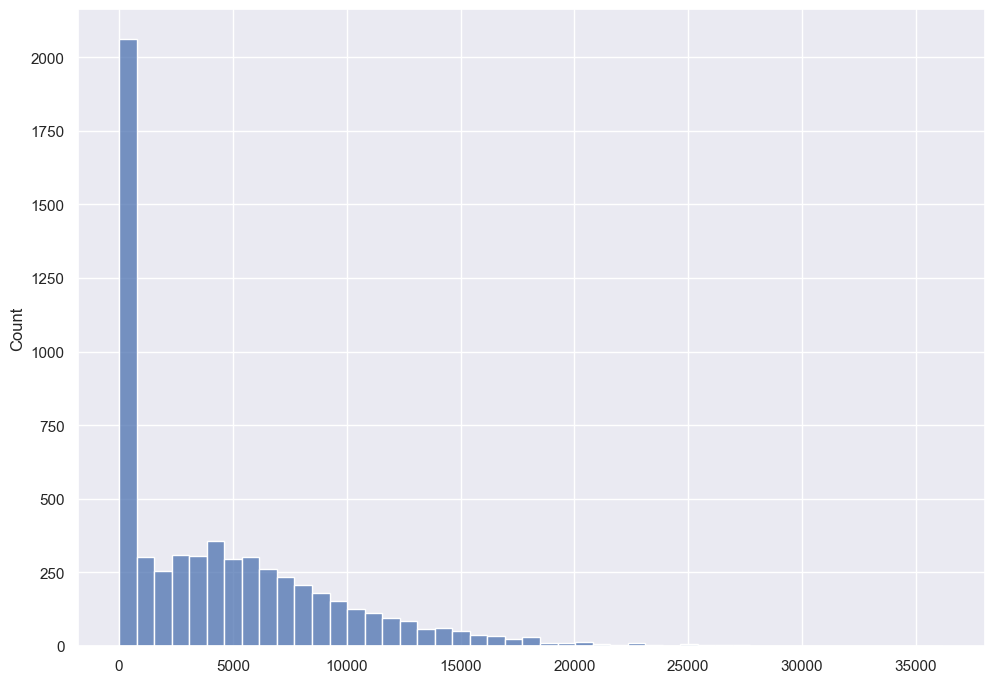

In [53]:
sns.histplot(treatment_revenues_l)

<Axes: ylabel='Count'>

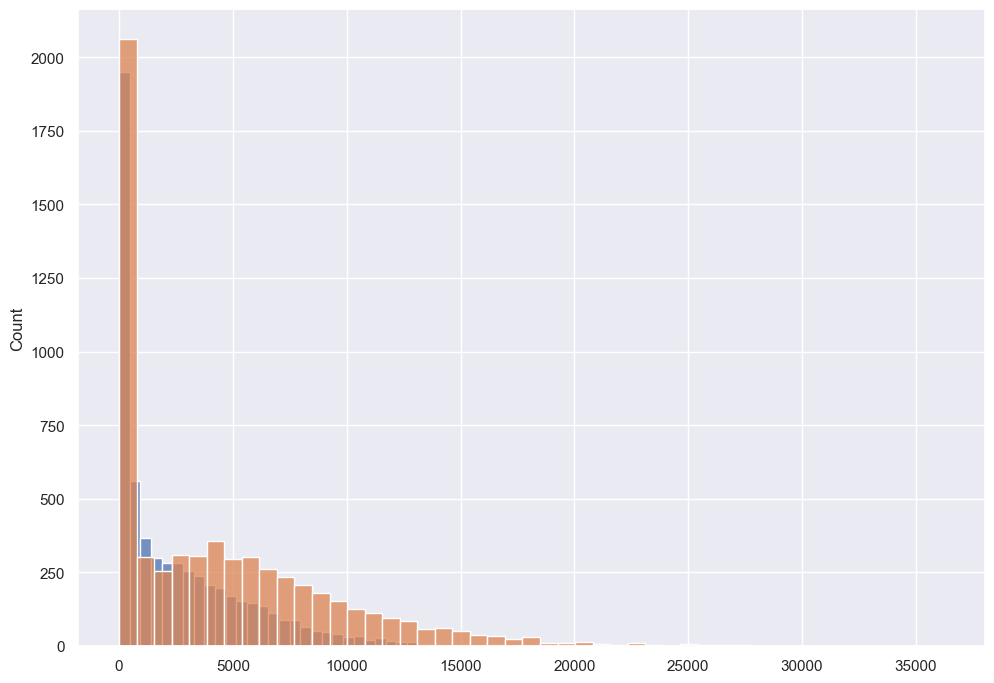

In [59]:
sns.histplot(control_revenues_l)
sns.histplot(treatment_revenues_l)

<Axes: ylabel='Count'>

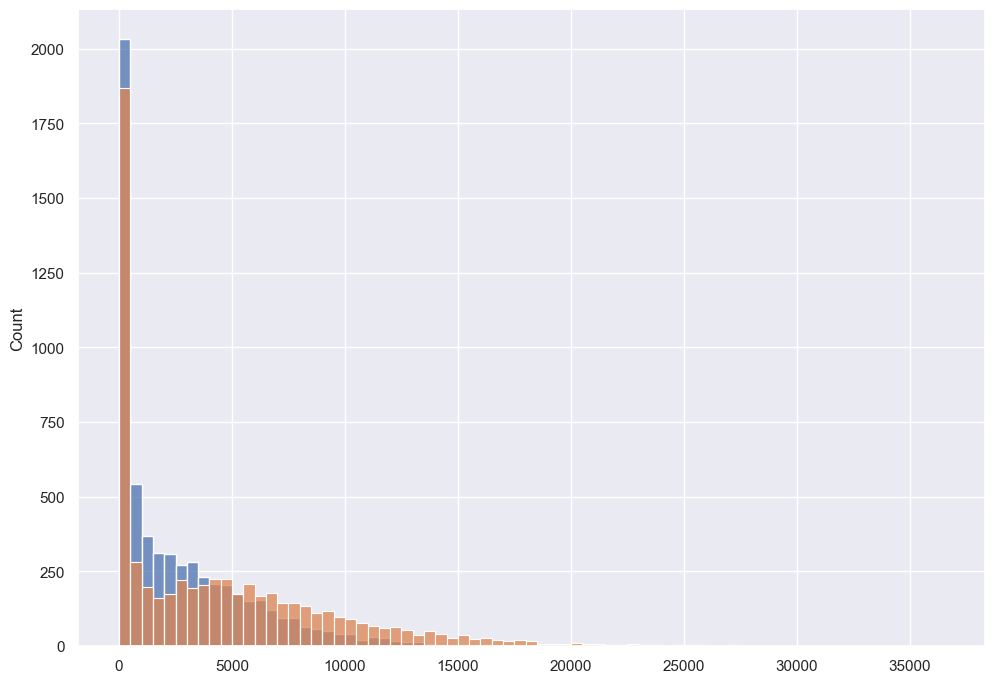

In [60]:
sns.histplot(control_revenues_l, binwidth=500)
sns.histplot(treatment_revenues_l, binwidth=500)

In [ ]:
#оранжевый график расширен вправо, ЭТО НАГЛЯДНО ДАЕТ ЗНАТЬ ЧТО СРЕДНЯЯ ПРИБЫЛЬ НА ПОЛЬЗОВАТЕЛЯ ВЫРОСЛА

<Axes: ylabel='Count'>

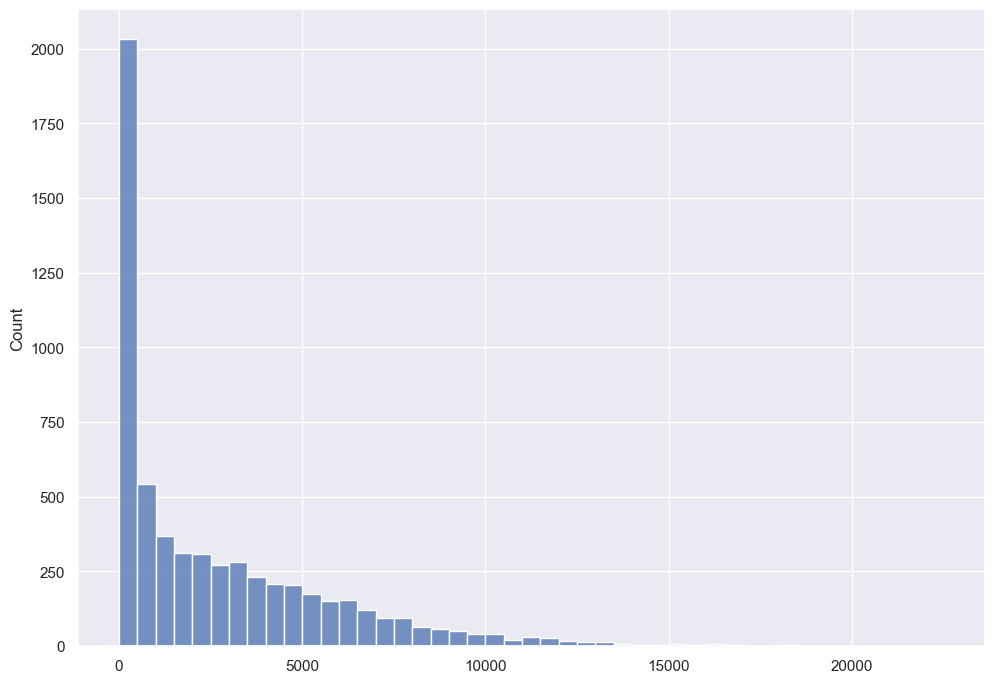

In [181]:
sns.histplot(control_revenues_l, binwidth=500)


In [215]:
ds = []

for i in range(10_000):
    d = random.choices(control_revenues_l, k=len(control_revenues_l))
    ds.append(sum(d) / len(d))
#СЧИТАЕМ 10 000 СЛУЧАЙНЫХ ВЫБОРОК

<Axes: ylabel='Count'>

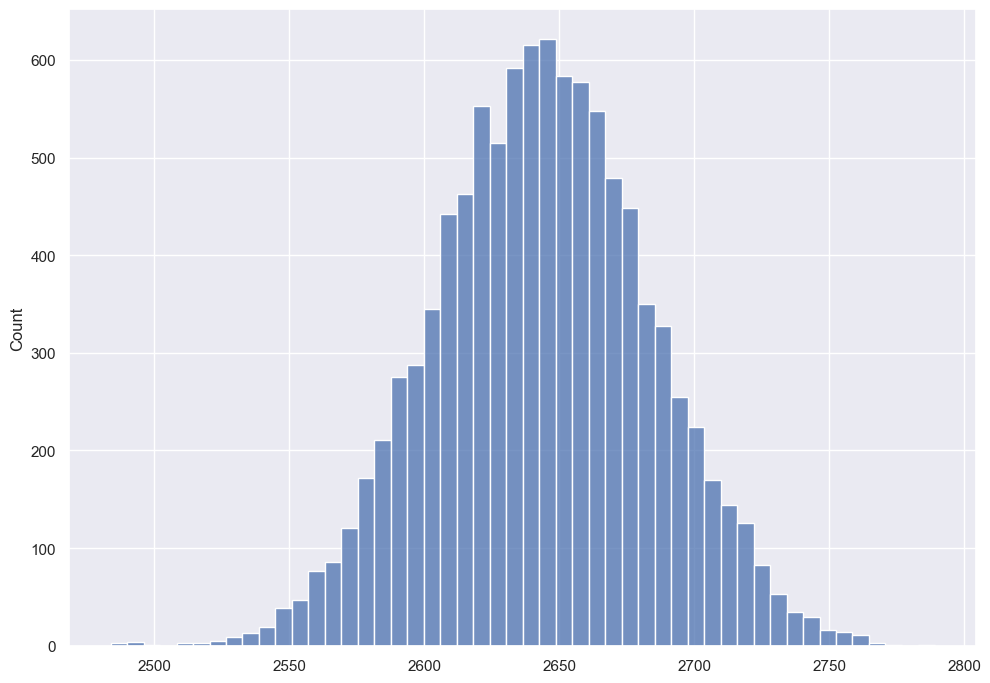

In [216]:
sns.histplot(ds, bins=50)

In [217]:
from scipy.stats import normaltest
# РАСПРЕДЕЛЕНИЕ НОРМАЛЬНОЕ

In [218]:
normaltest(ds)
#p.value <  5 значит распределние точно нормальное

NormaltestResult(statistic=0.26013607409649503, pvalue=0.8780356899316852)

In [85]:
from scipy.stats import ttest_ind

[Документация](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html) t-теста из scipy.

In [86]:
pd.Series(treatment_revenues_l).mean(), pd.Series(control_revenues_l).mean()
#средняя прибыль на человека из В группы на 2 тыс больше чем из А группы

(4427.101001669449, 2643.119493670886)

In [87]:
ttest_ind(treatment_revenues_l, control_revenues_l, equal_var=False)


Ttest_indResult(statistic=24.233967540582896, pvalue=3.363478798853414e-126)

## 4. Интерпретация результата

### Стало ли больше покупок?

In [ ]:
#мы уже поняли что результат положителен, но нужно понять, на что конкретно влияет новый алгоритм рекомендаций

In [153]:
len(treatment_purchases), len(control_purchases)
#количество покупок почти одинаковое, сильно разницы нет

(5879, 5944)

<Axes: xlabel='date_time', ylabel='Count'>

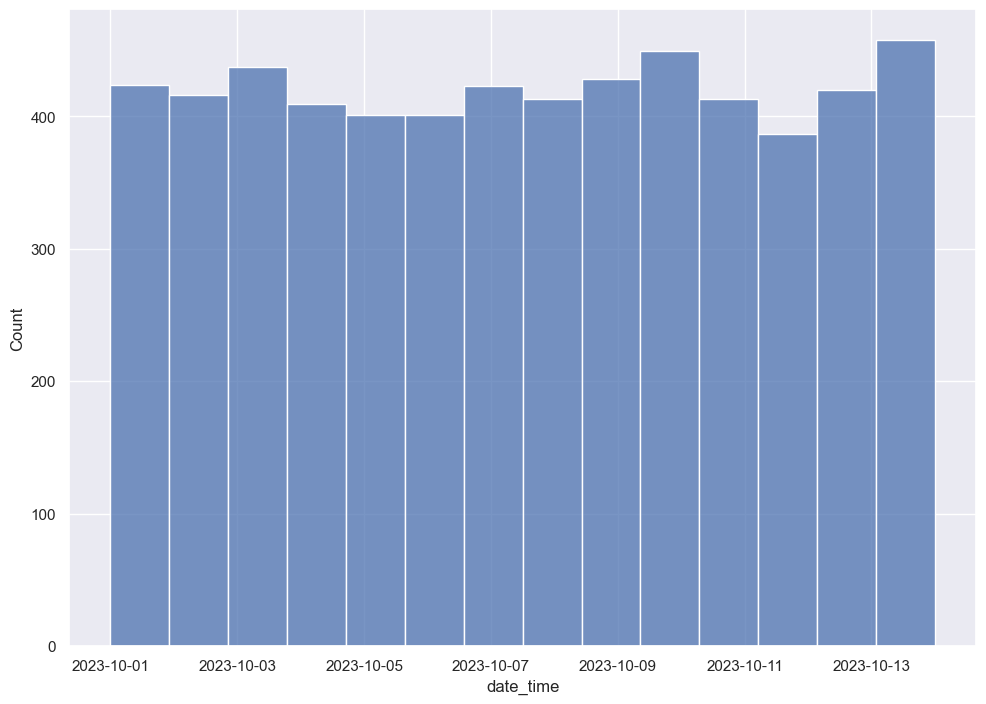

In [154]:
sns.histplot(treatment_purchases['date_time'].dt.floor('D'), bins=14)

<Axes: xlabel='date_time', ylabel='Count'>

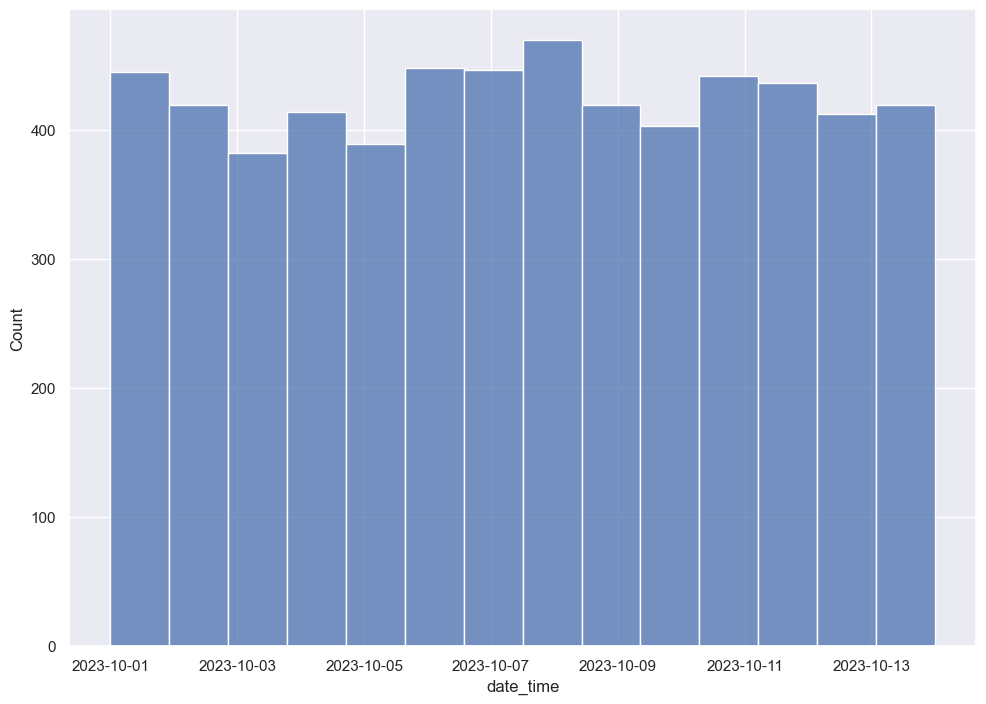

In [155]:
sns.histplot(control_purchases['date_time'].dt.floor('D'), bins=14)

In [156]:
treatment_user_purchases = treatment_purchases \
    .groupby('user_id', as_index=False) \
    .agg({'id': 'count'})

control_user_purchases = control_purchases \
    .groupby('user_id', as_index=False) \
    .agg({'id': 'count'})
#количество уникальных покупок тоже почти не отличается

<Axes: xlabel='id', ylabel='Count'>

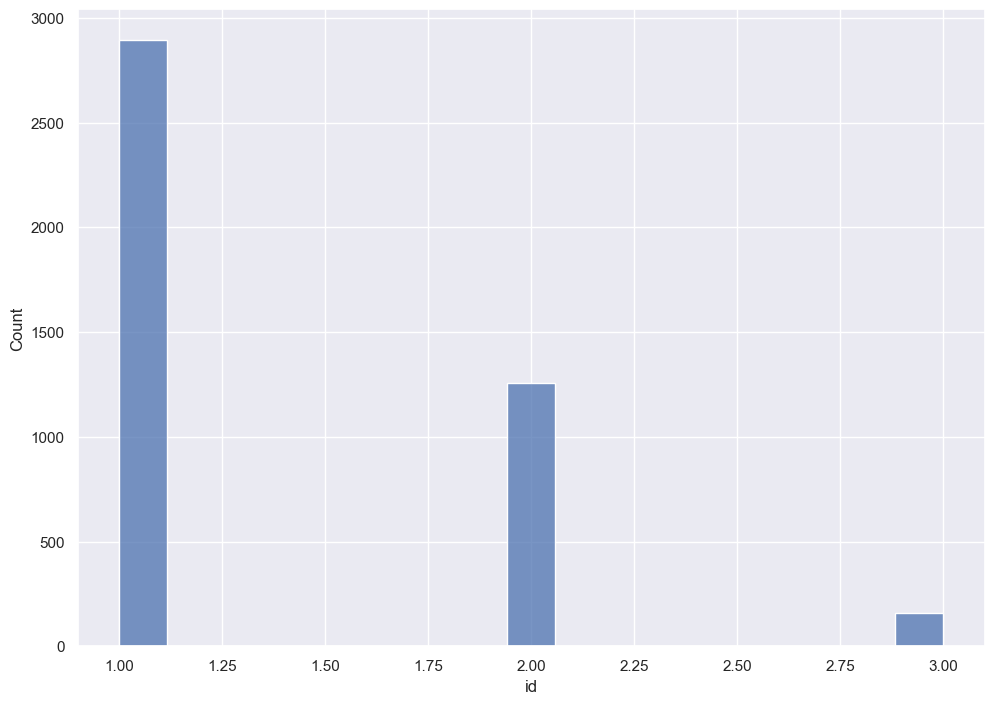

In [157]:
sns.histplot(treatment_user_purchases['id'])

In [158]:
treatment_user_purchases['id'].mean()

1.3643536783476444

<Axes: xlabel='id', ylabel='Count'>

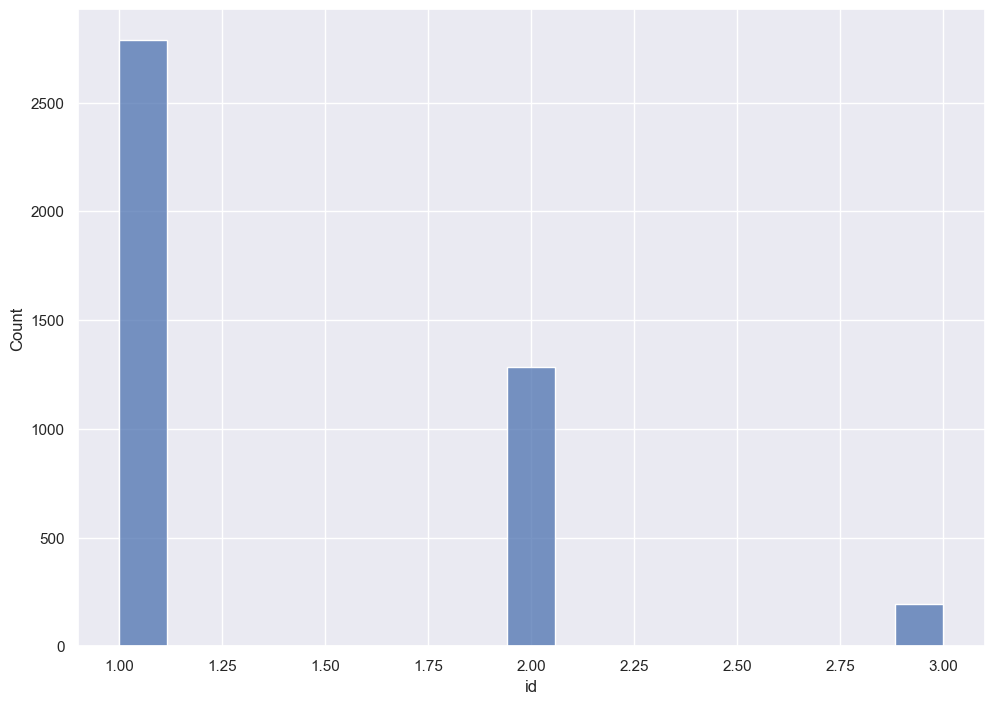

In [159]:
sns.histplot(control_user_purchases['id'])

In [160]:
control_user_purchases['id'].mean()

1.3923635511829469

In [219]:
treatment_user_purchases['id'].mean()
#среднее число покупок тоже 

1.3643536783476444

### Стали ли покупать больше товаров?

In [161]:
treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id')

,id,user_id,date_time,purchase_id,good_id,amount,was_in_recommended_goods
0,11833,12987,2023-10-01 00:02:30,11833,14,1,False
1,11833,12987,2023-10-01 00:02:30,11833,11,1,False
2,11833,12987,2023-10-01 00:02:30,11833,27,1,False
3,11833,12987,2023-10-01 00:02:30,11833,53,1,False
4,11836,4791,2023-10-01 00:07:04,11836,88,1,False
...,...,...,...,...,...,...,...
44662,26721,9557,2023-10-14 23:58:28,26721,27,1,False
44663,26721,9557,2023-10-14 23:58:28,26721,73,1,True
44664,26721,9557,2023-10-14 23:58:28,26721,6,1,True
44665,26721,9557,2023-10-14 23:58:28,26721,37,1,True


In [162]:
treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby('purchase_id', as_index=False) \
    .agg({'good_id': 'count'}) \
    ['good_id'].mean()


7.597720700799456

In [163]:
control_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby('purchase_id', as_index=False) \
    .agg({'good_id': 'count'}) \
    ['good_id'].mean()

4.425302826379542

In [ ]:
#но в каждой покупке в среднем на 3 товара больше => на это и повлиял наш алгоритм

In [164]:
treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby(['purchase_id', 'user_id'], as_index=False) \
    .agg({'good_id': 'count'}) \
    .groupby('user_id', as_index=False) \
    .agg({'good_id': 'mean'})

,user_id,good_id
0,2,13.0
1,6,1.0
2,10,7.0
3,12,1.0
4,13,7.0
...,...,...
4304,14988,3.0
4305,14994,4.0
4306,14996,4.0
4307,14998,12.0


In [165]:
treatment_user_goods = treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby(['purchase_id', 'user_id'], as_index=False) \
    .agg({'good_id': 'count'}) \
    .groupby('user_id', as_index=False) \
    .agg({'good_id': 'mean'})

control_user_goods = control_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby(['purchase_id', 'user_id'], as_index=False) \
    .agg({'good_id': 'count'}) \
    .groupby('user_id', as_index=False) \
    .agg({'good_id': 'mean'})

In [166]:
treatment_user_goods['good_id'].mean(), control_user_goods['good_id'].mean()

(7.621528583584745, 4.408995080815179)

In [167]:
control_user_goods['good_id'].max() - control_user_goods['good_id'].min()

22.0

<Axes: xlabel='good_id', ylabel='Count'>

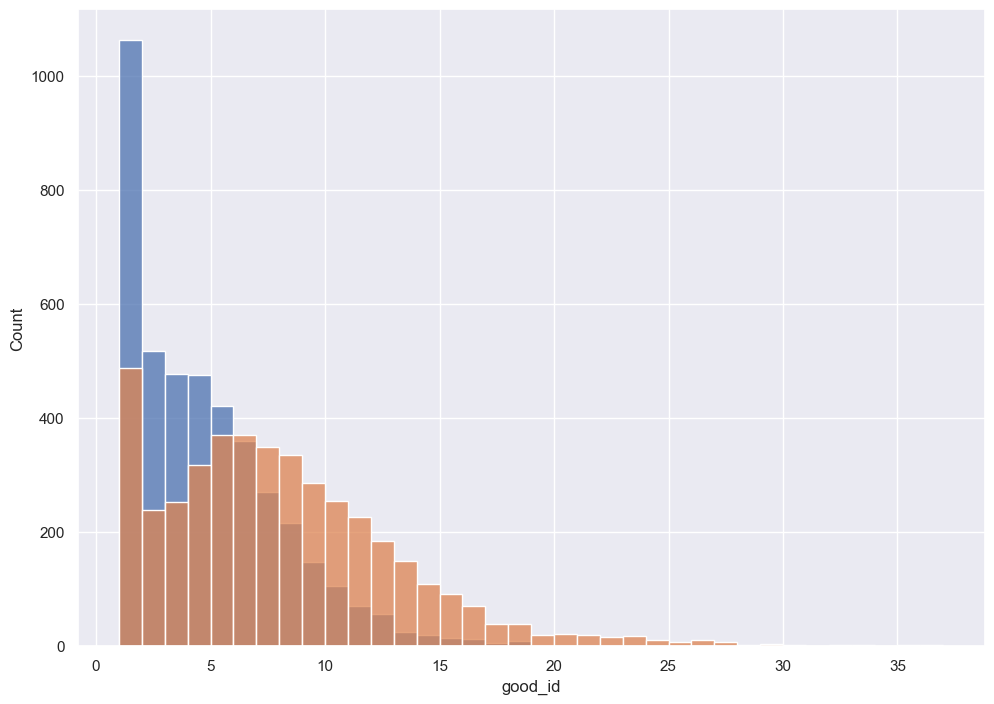

In [168]:
sns.histplot(control_user_goods['good_id'], binwidth=1)
sns.histplot(treatment_user_goods['good_id'], binwidth=1)

### Стали ли покупать больше товаров из рекомендаций?

In [169]:
purchase_good

,purchase_id,good_id,amount,was_in_recommended_goods
0,15495,34,2,False
1,42640,48,1,False
2,42640,36,1,False
3,42640,12,2,True
4,42640,35,1,True
...,...,...,...,...
352052,53057,54,1,False
352053,72053,37,1,False
352054,72053,7,1,False
352055,72053,24,1,True


In [170]:
treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    ['was_in_recommended_goods'].mean()


0.4482056104058925

In [171]:
control_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    ['was_in_recommended_goods'].mean()

0.30003041362530414

In [ ]:
#среднее % товаров куленных по рекомендации вырос в 1.5 раза (победа)

In [172]:
treatment_recommended_purchases = treatment_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby(['user_id'], as_index=False) \
    .agg({'was_in_recommended_goods': 'mean'})

control_recommended_purchases = control_purchases \
    .merge(purchase_good, left_on='id', right_on='purchase_id') \
    .groupby(['user_id'], as_index=False) \
    .agg({'was_in_recommended_goods': 'mean'})

In [173]:
treatment_recommended_purchases['was_in_recommended_goods'].mean(), \
    control_recommended_purchases['was_in_recommended_goods'].mean()

(0.4501345936177547, 0.2970048135612763)

<Axes: xlabel='was_in_recommended_goods', ylabel='Count'>

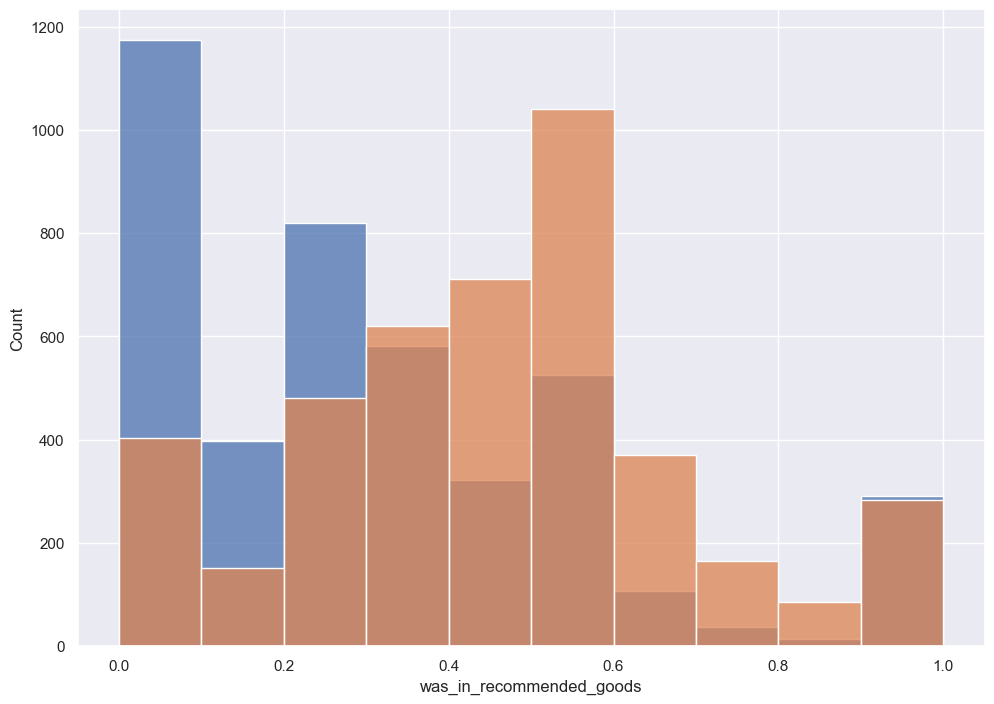

In [174]:
sns.histplot(control_recommended_purchases['was_in_recommended_goods'], binwidth=0.1)
sns.histplot(treatment_recommended_purchases['was_in_recommended_goods'], binwidth=0.1)

In [1]:
#ИТОГ: НОВЫЙ АЛГОРИТМ ЛУШЧЕ СТАРОГО

NameError: name 'git' is not defined